## Setup and Configuration

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Configuration
NUM_POINTS = 10_000
DIMENSION = 128

# Product Quantization parameters
PQ_M = 4                    # Number of subquantizers
PQ_NBITS = 4                # Bits per subquantizer (16 codes per subspace)
# Total possible codes: (2^nbits)^M = 16^4 = 65,536

# Distributions to test - more skewed versions
DISTRIBUTIONS = [
    'uniform',               # Baseline: no skew
    'normal',                # Moderate skew
    'heavy_tailed',          # Student's t-distribution (heavy tails)
    'mixture_gaussians',     # Multi-modal with extreme separation
    'zipf',                  # Power-law skewed
    'exponential',           # Exponentially decaying
]

# Mixture of Gaussians parameters - MORE EXTREME
MIX_NUM_COMPONENTS = 3       # Fewer, more distinct components
MIX_COMPONENT_STD = 0.1      # Tighter clusters (was 0.3)
MIX_SEPARATION = 5.0         # Larger separation between components

# Zipf parameters - MORE SKEWED
ZIPF_ALPHA = 2.5             # More extreme power law (was 1.5)

# Heavy-tailed distribution parameters
STUDENT_T_DF = 2             # Degrees of freedom (lower = heavier tails)

# Exponential parameters
EXPONENTIAL_LAMBDA = 2.0     # Rate parameter

# Create figures directory
FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration:")
print(f"  Points: {NUM_POINTS}, Dimension: {DIMENSION}")
print(f"  PQ: M={PQ_M}, nbits={PQ_NBITS} (max {2**PQ_NBITS}^{PQ_M} = {(2**PQ_NBITS)**PQ_M:,} possible codes)")
print(f"  Distributions: {DISTRIBUTIONS}")
print(f"  Figures directory: {FIGURES_DIR.resolve()}")
print(f"\nDistribution Parameters (MORE SKEWED):")
print(f"  Zipf alpha: {ZIPF_ALPHA} (higher = more skewed)")
print(f"  Mixture components: {MIX_NUM_COMPONENTS}, std: {MIX_COMPONENT_STD}, separation: {MIX_SEPARATION}")
print(f"  Student-t df: {STUDENT_T_DF} (lower = heavier tails)")
print(f"  Exponential lambda: {EXPONENTIAL_LAMBDA}")

/home/mohsen/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Configuration:
  Points: 10000, Dimension: 128
  PQ: M=4, nbits=4 (max 16^4 = 65,536 possible codes)
  Distributions: ['uniform', 'normal', 'heavy_tailed', 'mixture_gaussians', 'zipf', 'exponential']
  Figures directory: /home/mohsen/kvcache/hira/tests/pq_disadv/figures

Distribution Parameters (MORE SKEWED):
  Zipf alpha: 2.5 (higher = more skewed)
  Mixture components: 3, std: 0.1, separation: 5.0
  Student-t df: 2 (lower = heavier tails)
  Exponential lambda: 2.0


## Generate Data from Different Distributions

In [2]:
def generate_data(distribution: str, num_points: int, dimension: int, seed: int = 42) -> torch.Tensor:
    """
    Generate data from different distributions.
    
    Args:
        distribution: Type of distribution
        num_points: Number of data points
        dimension: Dimension of each point
        seed: Random seed
        
    Returns:
        Data points [num_points, dimension]
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    if distribution == 'uniform':
        # Uniform in [-1, 1] - baseline with no skew
        data = torch.rand(num_points, dimension) * 2 - 1
        
    elif distribution == 'normal':
        # Standard normal - moderate, symmetric
        data = torch.randn(num_points, dimension)
        
    elif distribution == 'heavy_tailed':
        # Student's t-distribution with low df for heavy tails
        # This creates extreme outliers and clustering around center
        from scipy.stats import t
        data_np = t.rvs(df=STUDENT_T_DF, size=(num_points, dimension))
        data = torch.from_numpy(data_np).float()
        
    elif distribution == 'mixture_gaussians':
        # Mixture of Gaussians with EXTREME separation
        data = torch.zeros(num_points, dimension)
        component_size = num_points // MIX_NUM_COMPONENTS
        
        for i in range(MIX_NUM_COMPONENTS):
            start_idx = i * component_size
            end_idx = (i + 1) * component_size if i < MIX_NUM_COMPONENTS - 1 else num_points
            
            # Create well-separated centers
            center = torch.randn(dimension) * MIX_SEPARATION
            # Tight clusters around each center
            data[start_idx:end_idx] = center + torch.randn(end_idx - start_idx, dimension) * MIX_COMPONENT_STD
            
    elif distribution == 'zipf':
        # VERY skewed Zipf-distributed along dimensions
        data = torch.zeros(num_points, dimension)
        
        # Generate Zipf weights with higher alpha (more extreme)
        ranks = torch.arange(1, dimension + 1, dtype=torch.float32)
        zipf_weights = 1.0 / (ranks ** ZIPF_ALPHA)
        zipf_weights = zipf_weights / zipf_weights.sum()
        
        # Generate data with Zipf-weighted dimensions
        for i in range(num_points):
            random_values = torch.randn(dimension)
            data[i] = random_values * torch.sqrt(zipf_weights * dimension)
            
    elif distribution == 'exponential':
        # Exponential distribution - creates skewed, non-negative data
        # Then center it for fairness
        from scipy.stats import expon
        data_np = expon.rvs(scale=1.0/EXPONENTIAL_LAMBDA, size=(num_points, dimension))
        data = torch.from_numpy(data_np).float()
        # Center the data
        data = data - data.mean(dim=0, keepdim=True)
            
    else:
        raise ValueError(f"Unknown distribution: {distribution}")
    
    return data

# Generate data for all distributions
all_data = {}
for dist in DISTRIBUTIONS:
    print(f"Generating {dist} distribution...")
    data = generate_data(dist, NUM_POINTS, DIMENSION, SEED)
    all_data[dist] = data
    print(f"  Shape: {data.shape}, Mean: {data.mean():.4f}, Std: {data.std():.4f}")

print(f"\nGenerated data for {len(all_data)} distributions")

Generating uniform distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0008, Std: 0.5772
Generating normal distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0004, Std: 1.0001
Generating heavy_tailed distribution...
  Shape: torch.Size([10000, 128]), Mean: 0.0018, Std: 4.2805
Generating mixture_gaussians distribution...
  Shape: torch.Size([10000, 128]), Mean: 0.2390, Std: 4.8578
Generating zipf distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0016, Std: 0.9990
Generating exponential distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0000, Std: 0.5006

Generated data for 6 distributions


## Product Quantization Implementation

In [3]:
class SimpleProductQuantizer:
    """
    Simple Product Quantization implementation.
    """
    def __init__(self, M: int, nbits: int):
        """
        Args:
            M: Number of subquantizers
            nbits: Number of bits per subquantizer (creates 2^nbits codes per subspace)
        """
        self.M = M
        self.nbits = nbits
        self.k = 2 ** nbits  # Number of codes per subquantizer
        self.codebooks = None
        self.d_sub = None
        
    def fit(self, data: torch.Tensor):
        """
        Train the product quantizer.
        
        Args:
            data: Training data [n_points, dimension]
        """
        n, d = data.shape
        assert d % self.M == 0, "Dimension must be divisible by M"
        
        self.d_sub = d // self.M  # Dimension of each subspace
        self.codebooks = []
        
        # Train a codebook for each subspace
        for m in range(self.M):
            # Extract subspace
            start_idx = m * self.d_sub
            end_idx = (m + 1) * self.d_sub
            subspace_data = data[:, start_idx:end_idx]
            
            # Run k-means on this subspace
            from sklearn.cluster import KMeans
            kmeans = KMeans(n_clusters=self.k, random_state=SEED, n_init=10, max_iter=100)
            kmeans.fit(subspace_data.numpy())
            
            # Store codebook (centroids)
            self.codebooks.append(torch.from_numpy(kmeans.cluster_centers_).float())
    
    def encode(self, data: torch.Tensor) -> torch.Tensor:
        """
        Encode data into PQ codes.
        
        Args:
            data: Data to encode [n_points, dimension]
            
        Returns:
            PQ codes [n_points, M]
        """
        n = data.shape[0]
        codes = torch.zeros(n, self.M, dtype=torch.long)
        
        for m in range(self.M):
            # Extract subspace
            start_idx = m * self.d_sub
            end_idx = (m + 1) * self.d_sub
            subspace_data = data[:, start_idx:end_idx]
            
            # Find nearest centroid in this subspace
            codebook = self.codebooks[m]
            distances = torch.cdist(subspace_data, codebook)  # [n, k]
            codes[:, m] = torch.argmin(distances, dim=1)
        
        return codes

def pq_encode_and_analyze(data: torch.Tensor, M: int, nbits: int) -> dict:
    """
    Apply Product Quantization and analyze code distribution.
    
    Args:
        data: Data points [num_points, dimension]
        M: Number of subquantizers
        nbits: Bits per subquantizer
        
    Returns:
        Dictionary with code distribution statistics
    """
    # Create and train PQ
    pq = SimpleProductQuantizer(M=M, nbits=nbits)
    pq.fit(data)
    
    # Encode all points
    codes = pq.encode(data)  # [num_points, M]
    
    # Convert codes to unique identifiers
    # Treat each code vector as a unique ID
    code_strings = ['_'.join(map(str, code.tolist())) for code in codes]
    
    # Count points per unique code
    unique_codes, counts = np.unique(code_strings, return_counts=True)
    code_sizes = counts
    
    # Compute statistics
    stats = {
        'code_sizes': code_sizes,
        'num_unique_codes': len(unique_codes),
        'mean': np.mean(code_sizes),
        'std': np.std(code_sizes),
        'min': np.min(code_sizes),
        'max': np.max(code_sizes),
        'median': np.median(code_sizes),
        'cv': np.std(code_sizes) / np.mean(code_sizes) if np.mean(code_sizes) > 0 else 0,
    }
    
    return stats

# Apply PQ to all distributions
all_pq_stats = {}

print(f"Applying Product Quantization (M={PQ_M}, nbits={PQ_NBITS})...\n")
for dist in DISTRIBUTIONS:
    print(f"Encoding {dist} distribution...")
    stats = pq_encode_and_analyze(all_data[dist], M=PQ_M, nbits=PQ_NBITS)
    all_pq_stats[dist] = stats
    
    print(f"  Unique codes used: {stats['num_unique_codes']} / {(2**PQ_NBITS)**PQ_M} possible")
    print(f"  Mean code size: {stats['mean']:.2f}")
    print(f"  Std code size: {stats['std']:.2f}")
    print(f"  Min code size: {stats['min']}")
    print(f"  Max code size: {stats['max']}")
    print(f"  Median code size: {stats['median']:.2f}")
    print(f"  Coefficient of variation: {stats['cv']:.4f}")
    print()

print("Product Quantization complete!")

Applying Product Quantization (M=4, nbits=4)...

Encoding uniform distribution...
  Unique codes used: 9286 / 65536 possible
  Mean code size: 1.08
  Std code size: 0.28
  Min code size: 1
  Max code size: 4
  Median code size: 1.00
  Coefficient of variation: 0.2577

Encoding normal distribution...
  Unique codes used: 9297 / 65536 possible
  Mean code size: 1.08
  Std code size: 0.28
  Min code size: 1
  Max code size: 4
  Median code size: 1.00
  Coefficient of variation: 0.2591

Encoding heavy_tailed distribution...
  Unique codes used: 620 / 65536 possible
  Mean code size: 16.13
  Std code size: 16.79
  Min code size: 1
  Max code size: 77
  Median code size: 12.00
  Coefficient of variation: 1.0410

Encoding mixture_gaussians distribution...
  Unique codes used: 2403 / 65536 possible
  Mean code size: 4.16
  Std code size: 2.39
  Min code size: 1
  Max code size: 17
  Median code size: 4.00
  Coefficient of variation: 0.5739

Encoding zipf distribution...
  Unique codes used: 92

## Visualize PQ Code Distributions

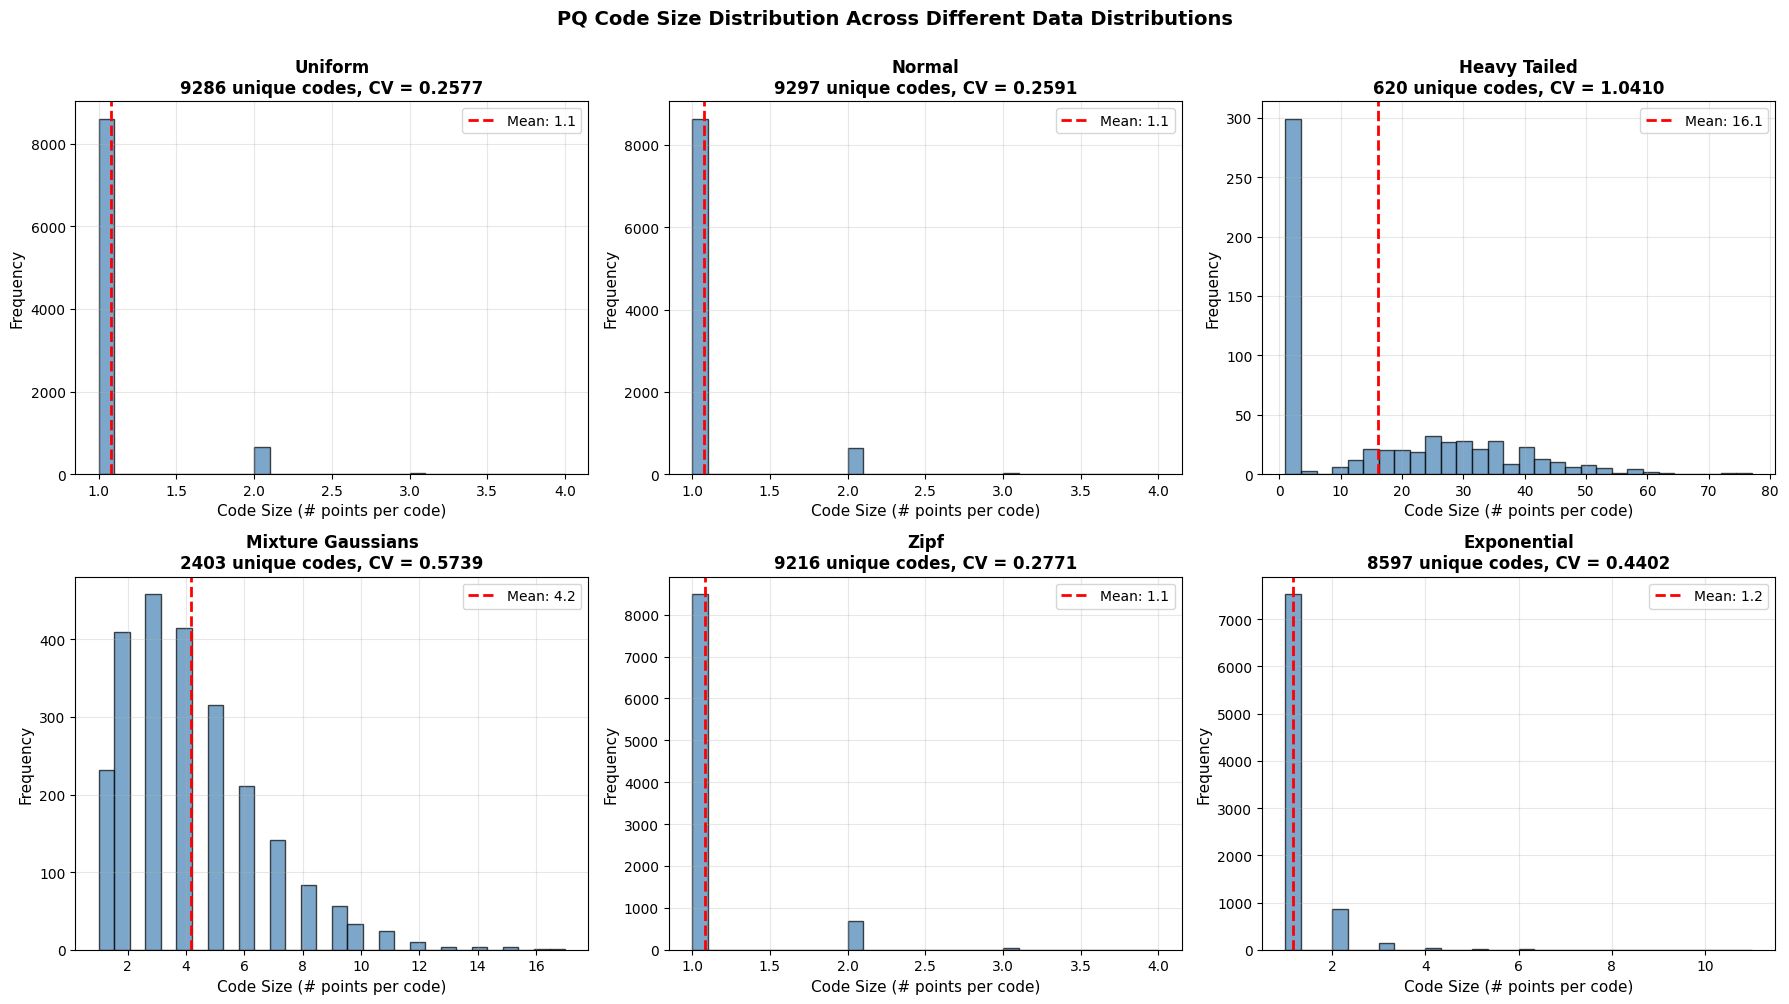


✓ Saved histogram plot to: figures/pq_code_size_histograms.png


In [4]:
# Plot 1: Histograms of PQ code sizes for each distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, dist in enumerate(DISTRIBUTIONS):
    ax = axes[idx]
    code_sizes = all_pq_stats[dist]['code_sizes']
    
    # Plot histogram
    ax.hist(code_sizes, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    
    # Add statistics as text
    mean_size = all_pq_stats[dist]['mean']
    cv = all_pq_stats[dist]['cv']
    num_codes = all_pq_stats[dist]['num_unique_codes']
    
    ax.axvline(mean_size, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_size:.1f}')
    
    ax.set_xlabel('Code Size (# points per code)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f"{dist.replace('_', ' ').title()}\n{num_codes} unique codes, CV = {cv:.4f}", fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('PQ Code Size Distribution Across Different Data Distributions', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'pq_code_size_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved histogram plot to: {FIGURES_DIR / 'pq_code_size_histograms.png'}")

## Summary Statistics Table

In [5]:
# Create summary table
summary_data = []
for dist in DISTRIBUTIONS:
    stats = all_pq_stats[dist]
    summary_data.append({
        'Distribution': dist.replace('_', ' ').title(),
        'Unique Codes': stats['num_unique_codes'],
        'Mean': f"{stats['mean']:.2f}",
        'Std': f"{stats['std']:.2f}",
        'Min': stats['min'],
        'Max': stats['max'],
        'Median': f"{stats['median']:.2f}",
        'CV': f"{stats['cv']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("SUMMARY: PQ Code Size Statistics")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)
print("\nCV = Coefficient of Variation (Std/Mean) - higher values indicate more skewed distributions")
print(f"Max possible codes: {(2**PQ_NBITS)**PQ_M:,}")


SUMMARY: PQ Code Size Statistics
     Distribution  Unique Codes  Mean   Std  Min  Max Median     CV
          Uniform          9286  1.08  0.28    1    4   1.00 0.2577
           Normal          9297  1.08  0.28    1    4   1.00 0.2591
     Heavy Tailed           620 16.13 16.79    1   77  12.00 1.0410
Mixture Gaussians          2403  4.16  2.39    1   17   4.00 0.5739
             Zipf          9216  1.09  0.30    1    4   1.00 0.2771
      Exponential          8597  1.16  0.51    1   11   1.00 0.4402

CV = Coefficient of Variation (Std/Mean) - higher values indicate more skewed distributions
Max possible codes: 65,536
